In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import scipy
import torch
import os

from scDisInFact import scdisinfact, create_scdisinfact_dataset

from metrics import calculate_metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
def run_scdisinfact(adata, batch_key, condition_key, dataset_name, cell_type_label=None):
    if np.max(adata.X) > 15:
        sc.pp.filter_cells(adata, min_genes=300)
        sc.pp.filter_genes(adata, min_cells=10)

        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)

    if adata.shape[1] > 3000:
        sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key=batch_key)
        adata = adata[:, adata.var["highly_variable"]].copy()
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=adata.shape[1], batch_key=batch_key)

    import warnings

    # Suppress all warnings
    warnings.filterwarnings("ignore")

    result_dir = "./scd/" + dataset_name + "/"
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    if isinstance(adata.X, scipy.sparse.spmatrix):
        adata.X = adata.X.toarray()

    counts = adata.X
    #print(counts[:10,:10])
    adata.obs["batch"] = adata.obs[batch_key].copy()
    meta_cells = adata.obs.copy()

    if isinstance(condition_key, str):
        condition_key = [condition_key]

    if not isinstance(condition_key, list):
        print("Wrong condition_key, must be string or list of string")

    data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key=condition_key, batch_key=batch_key, log_trans=False)

    # default setting of hyper-parameters
    reg_mmd_comm = 1e-4
    reg_mmd_diff = 1e-4
    reg_kl_comm = 1e-5
    reg_kl_diff = 1e-2
    reg_class = 1
    reg_gl = 1

    Ks = [8, 4]

    batch_size = 64
    nepochs = 100
    interval = 10
    lr = 5e-4
    lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]
    model = scdisinfact(data_dict=data_dict, Ks=Ks, batch_size=batch_size, interval=interval, lr=lr,
                        reg_mmd_comm=reg_mmd_comm, reg_mmd_diff=reg_mmd_diff, reg_gl=reg_gl, reg_class=reg_class,
                        reg_kl_comm=reg_kl_comm, reg_kl_diff=reg_kl_diff, seed=0, device=device)
    #model.train()
    #losses = model.train_model(nepochs=nepochs, recon_loss="NB")
    #torch.save(model.state_dict(), result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")
    model.load_state_dict(
        torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth", map_location=device))
    _ = model.eval()

    # one forward pass
    z_cs = []
    z_ds = []
    zs = []

    for dataset in data_dict["datasets"]:
        with torch.no_grad():
            # pass through the encoders
            dict_inf = model.inference(counts=dataset.counts_norm.to(model.device),
                                       batch_ids=dataset.batch_id[:, None].to(model.device), print_stat=True)
            # pass through the decoder
            dict_gen = model.generative(z_c=dict_inf["mu_c"], z_d=dict_inf["mu_d"],
                                        batch_ids=dataset.batch_id[:, None].to(model.device))
            z_c = dict_inf["mu_c"]
            z_d = dict_inf["mu_d"]
            z = torch.cat([z_c] + z_d, dim=1)
            mu = dict_gen["mu"]
            z_ds.append([x.cpu().detach().numpy() for x in z_d])
            z_cs.append(z_c.cpu().detach().numpy())
            zs.append(np.concatenate([z_cs[-1]] + z_ds[-1], axis=1))

    latent = np.concatenate(z_cs, axis=0)
    print(latent)
    meta_dict = {}
    for namei in meta_cells.columns.tolist():
        meta_dict[namei] = np.concatenate([x[namei].values for x in data_dict["meta_cells"]])

    meta_df = pd.DataFrame(meta_dict)
    adata_latent = ad.AnnData(X=latent)
    #adata_latent.var_names = adata.var_names
    adata_latent.obs = meta_df

    adata_latent.obsm["X_pca"]=latent
    adata_latent.obsm['main_effect']=latent
    
    adata_latent.write_h5ad("./scd/" + dataset_name + "_effect_modifier_space.h5ad")
    '''sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    for colori in [cell_type_label, condition_key, batch_key]:
        sc.pl.umap(adata_latent, color=colori, ncols=1)'''
        
    return adata_latent

In [3]:
def evaluate_scd_comprehensive(adata, cell_type_label, batch_key, condition_key, dataset_name):
    cell_type_key=cell_type_label
    print(dataset_name, "adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata.raw = None
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")

    main_effect_adata = ad.AnnData(adata.obsm['main_effect'], dtype=np.float32)
    #main_effect_adata.var_names = adata.var_names
    main_effect_adata.obs = adata.obs.copy()

    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    else:
        main_effect_adata.obsm['X_pca'] = main_effect_adata.X.copy()
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(main_effect_adata, color=colori, ncols=1)
    '''
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all_with_condition",
                      celltype_key=cell_type_key, all=True, n_neighbors=15,
                     savepath="./scd/" + dataset_name + "_main_effect.csv")
    print("-" * 20)
    '''

# Type 1 diabetes

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148073

Sanity check...
Finished.
Create scDisInFact datasets...


Finished.


[[-3.3363335  -0.17052034 -1.0160383  ... -1.318243    1.9978839
   2.7661593 ]
 [-1.826431    1.0140561   1.6698399  ... -2.8280585   0.37836725
   2.8306134 ]
 [-1.8389707   0.6891248   1.3822732  ... -2.1480613   0.4078245
   1.8974243 ]
 ...
 [-2.9417276   1.4882987   2.1021104  ... -2.106747    0.8883149
   2.2378445 ]
 [-2.7042542   0.67088974  0.9173583  ... -1.9665762   0.27058014
   1.8964233 ]
 [ 2.2461295  -2.2023659  -2.5333822  ... -0.79372925  2.4974587
   1.5134573 ]]


Finish get space, now evaluating
t1d adata preprocessing...
adata preprocessing...


batch_all ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']


batch_all_with_condition ['HPAP019__AAB' 'HPAP020__T1D' 'HPAP021__T1D' 'HPAP022__Control'
 'HPAP023__T1D' 'HPAP024__AAB' 'HPAP026__Control' 'HPAP028__T1D'
 'HPAP029__AAB' 'HPAP032__T1D' 'HPAP034__Control' 'HPAP035__Control'
 'HPAP036__Control' 'HPAP037__Control' 'HPAP038__AAB' 'HPAP039__Control'
 'HPAP040__Control' 'HPAP042__Control' 'HPAP043__AAB' 'HPAP044__Control'
 'HPAP045__AAB' 'HPAP047__Control' 'HPAP049__AAB' 'HPAP050__AAB']


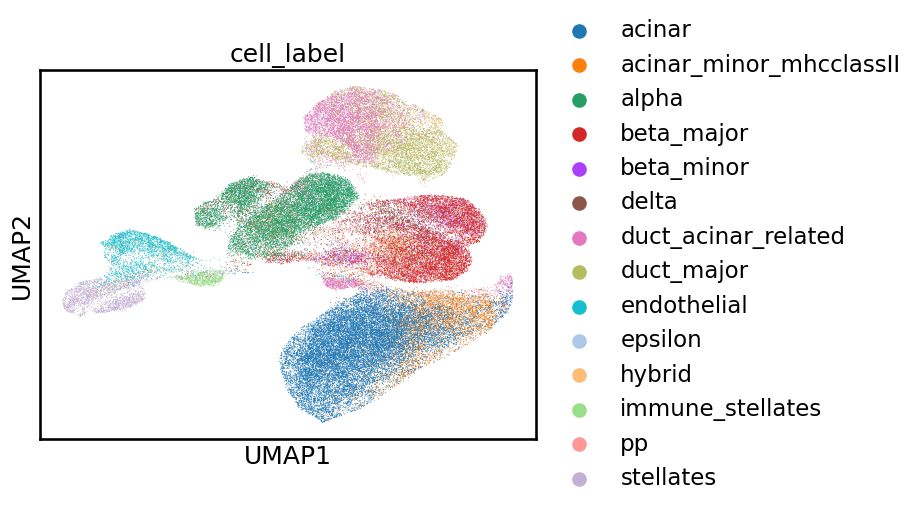

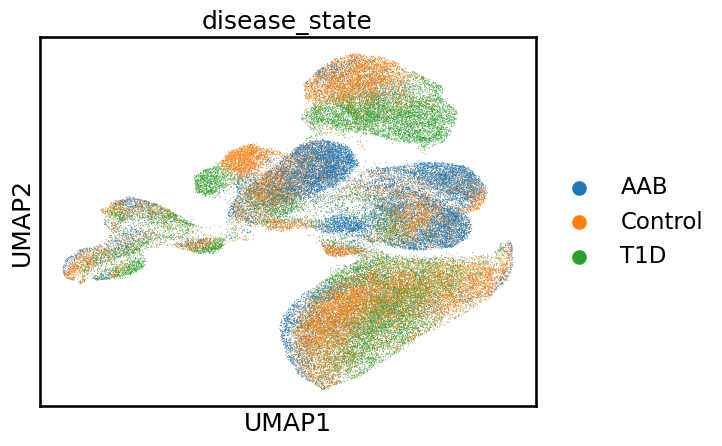

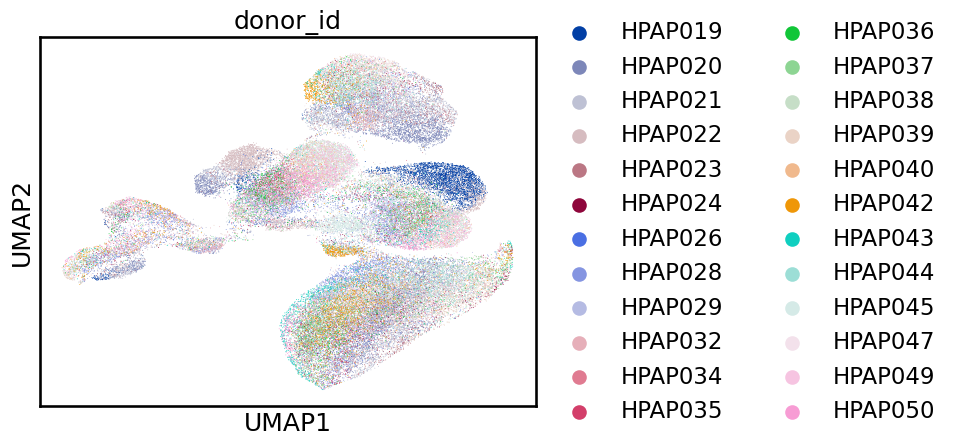

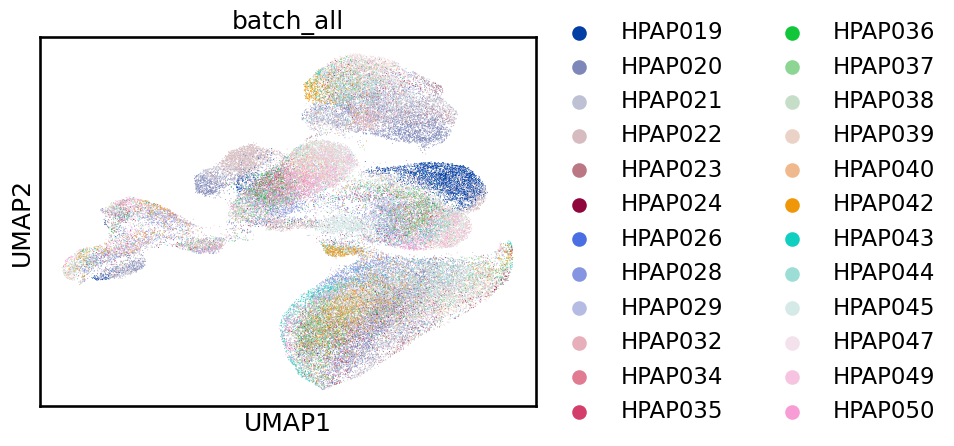

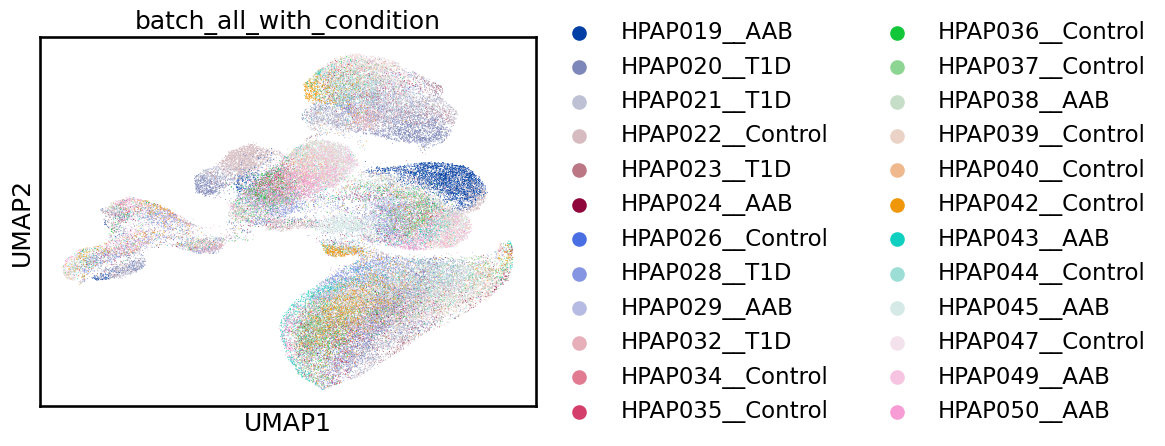

In [4]:
adata = sc.read_h5ad('../case_control/data/t1d.h5ad')
adata_latent=run_scdisinfact(adata=adata, batch_key="donor_id", condition_key="disease_state", cell_type_label='cell_label', dataset_name="t1d")
print("Finish get space, now evaluating")
evaluate_scd_comprehensive(adata=adata_latent, batch_key="donor_id", condition_key="disease_state", cell_type_label='cell_label', dataset_name="t1d")

# Human kidney multiomics atlas

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE211785

Sanity check...
Finished.
Create scDisInFact datasets...


Finished.


[[-0.79125005 -0.6484567  -4.0988517  ... -0.52273047  0.01875884
   0.15843427]
 [-0.7922194  -0.54719883 -4.2785835  ... -0.3430548   0.07854068
  -0.09651712]
 [-0.89545274 -0.59834975 -4.5783134  ... -0.6454527   0.04224465
   0.02721164]
 ...
 [-0.8637405  -0.4078767  -4.515947   ... -0.43234515  0.12106501
  -0.09555721]
 [-0.55665153 -0.6613689  -4.1066985  ... -0.15415607  0.20305169
  -0.49910814]
 [-0.6320862  -0.04899495 -3.0741076  ... -0.64961666  0.3549656
   0.23251158]]


kidney adata preprocessing...
adata preprocessing...


batch_all ['HK1584.SC' 'HK1585.SC' 'HK1588.SC' 'HK1593.SC' 'HK1594.SC' 'HK1597.SC'
 'HK1632.SC' 'HK1634.SC' 'HK1635_G.SC' 'HK1635_T.SC' 'HK1650_G.SC'
 'HK1650_T.SC' 'HK1664_G.SC' 'HK1664_T.SC' 'HK1770.SC' 'HK1997.SC'
 'HK2558.SN' 'HK2596.SN' 'HK2662.SC' 'HK2663_SN' 'HK2711.SN' 'HK2713.SC'
 'HK2739.SN' 'HK2770.SC' 'HK2770_SN' 'HK2774.SC' 'HK2774.SN' 'HK2833.SC'
 'HK2833.SN' 'HK2844.SN' 'HK2862.SN' 'HK2867.SC' 'HK2867.SN' 'HK2868.SN'
 'HK2891.SC' 'HK2891.SN' 'HK2893.SC' 'HK2893.SN' 'HK2895.SC' 'HK2895.SN'
 'HK2896.SC' 'HK2898.SN' 'HK2899.SC' 'HK2899.SN' 'HK2923.SC' 'HK2924.SC'
 'HK2976.SN']


batch_all_with_condition ['HK1584.SC__Disease' 'HK1585.SC__Control' 'HK1588.SC__Control'
 'HK1593.SC__Disease' 'HK1594.SC__Disease' 'HK1597.SC__Disease'
 'HK1632.SC__Disease' 'HK1634.SC__Disease' 'HK1635_G.SC__Disease'
 'HK1635_T.SC__Disease' 'HK1650_G.SC__Disease' 'HK1650_T.SC__Disease'
 'HK1664_G.SC__Control' 'HK1664_T.SC__Control' 'HK1770.SC__Disease'
 'HK1997.SC__Control' 'HK2558.SN__Disease' 'HK2596.SN__Disease'
 'HK2662.SC__Control' 'HK2663_SN__Disease' 'HK2711.SN__Disease'
 'HK2713.SC__Control' 'HK2739.SN__Disease' 'HK2770.SC__Disease'
 'HK2770_SN__Control' 'HK2774.SC__Disease' 'HK2774.SN__Disease'
 'HK2833.SC__Control' 'HK2833.SN__Control' 'HK2844.SN__Disease'
 'HK2862.SN__Disease' 'HK2867.SC__Control' 'HK2867.SN__Control'
 'HK2868.SN__Disease' 'HK2891.SC__Control' 'HK2891.SN__Control'
 'HK2893.SC__Control' 'HK2893.SN__Control' 'HK2895.SC__Control'
 'HK2895.SN__Control' 'HK2896.SC__Control' 'HK2898.SN__Control'
 'HK2899.SC__Control' 'HK2899.SN__Control' 'HK2923.SC__Control'
 'H

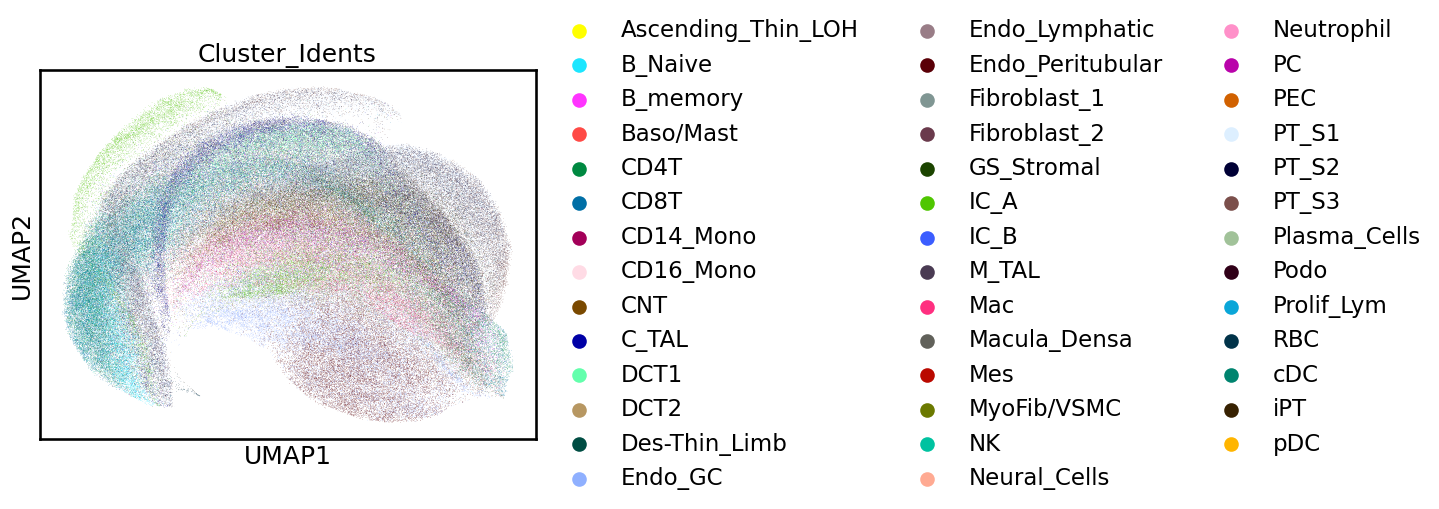

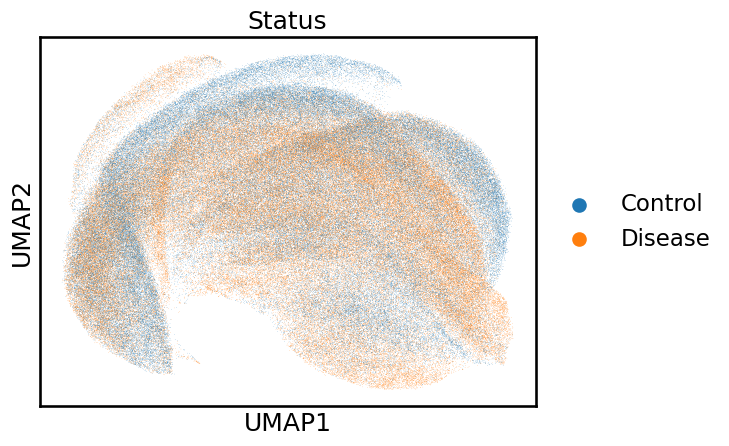

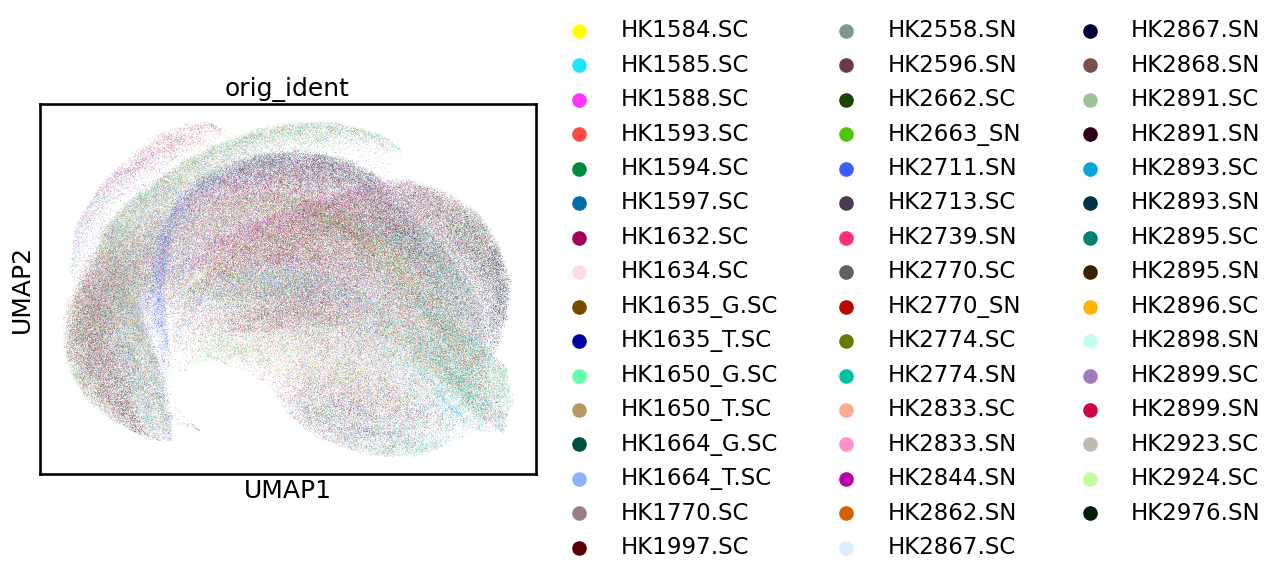

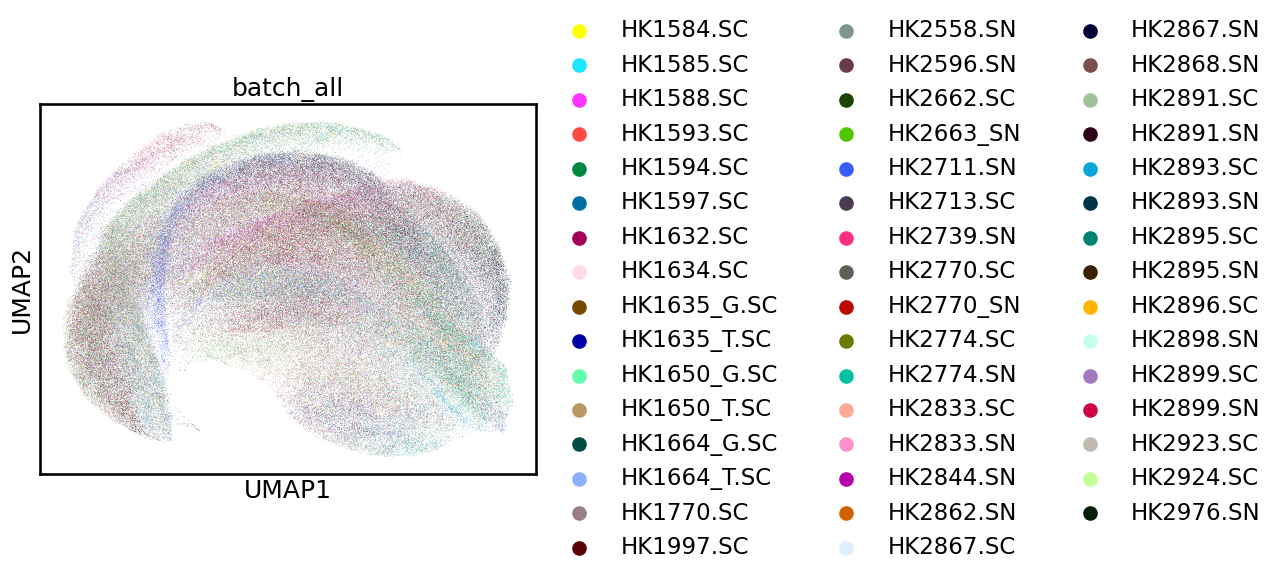

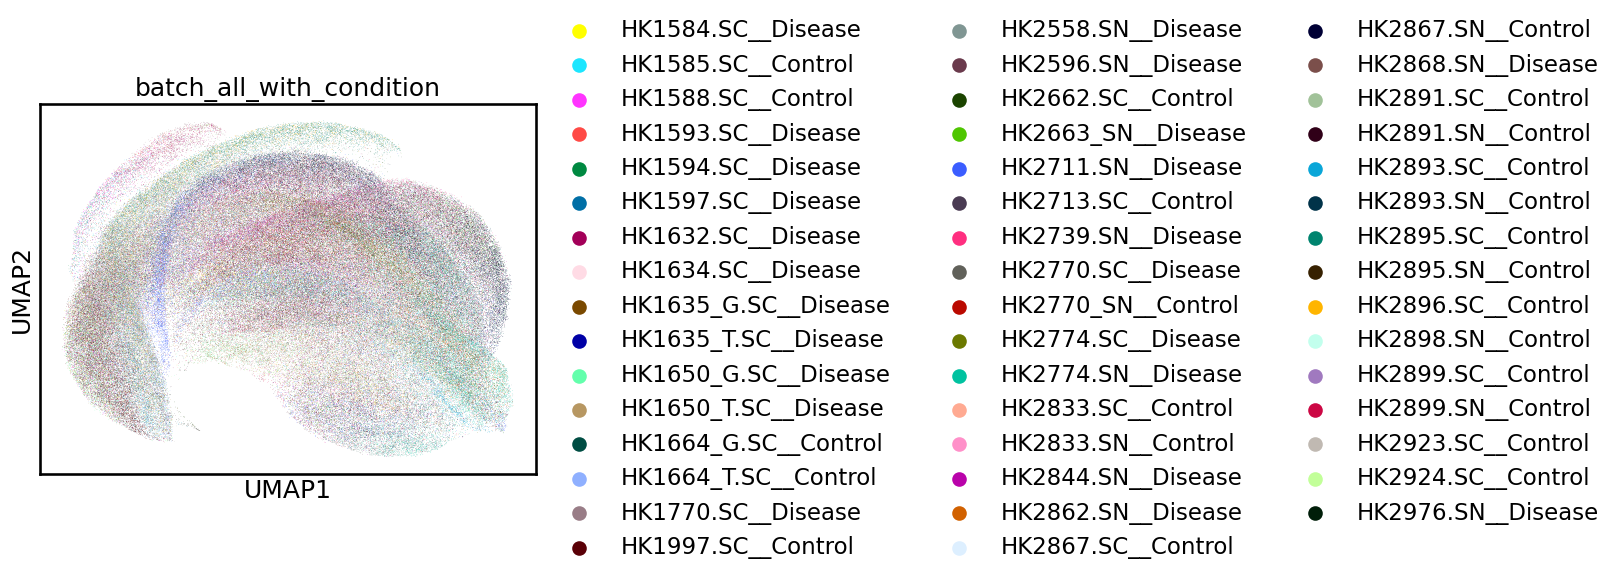

In [5]:
adata=sc.read_h5ad("../case_control/data/GSE211785_Susztak_SC_SN_ATAC_merged_PreSCVI_final.h5ad")
adata=adata[adata.obs["tech"].isin(['SC_RNA','SN_RNA'])].copy()
adata_latent=run_scdisinfact(adata=adata, batch_key="orig_ident", condition_key="Status", cell_type_label='Cluster_Idents', dataset_name="kidney")
evaluate_scd_comprehensive(adata=adata_latent, batch_key="orig_ident", condition_key="Status", cell_type_label='Cluster_Idents', dataset_name="kidney")

# Mouse radiation experiment dataset

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE280883

Sanity check...
Finished.
Create scDisInFact datasets...


Finished.


[[ 4.7969203e+00  2.1308908e+00  5.9740839e+00 ... -1.6994405e+00
  -3.7733865e+00  9.4848946e-02]
 [ 5.6379962e+00  6.3515492e-03  8.0385122e+00 ... -4.1961370e+00
  -3.3546019e+00  1.9987378e+00]
 [ 4.8443818e+00 -5.9443641e-01  7.9075580e+00 ... -3.9705803e+00
  -3.2786090e+00  2.1198852e+00]
 ...
 [ 1.1230267e+00 -3.7932854e+00  1.2322986e+00 ... -2.5564799e+00
   2.8978591e+00  8.2728583e-01]
 [-1.3341657e+00 -4.3366134e-01  1.3314997e+00 ...  6.7231113e-01
  -4.1919932e+00  2.0816515e-01]
 [ 1.7631519e+00 -8.7346882e-01  1.9294487e+00 ... -1.6501424e+00
   6.8014640e-01 -1.3422889e+00]]


mouse adata preprocessing...
adata preprocessing...


batch_all ['D10__CY__1.0' 'D10__LL__1.0' 'D20__CY__1.0' 'D2__CY__1.0' 'D2__CY__2.0'
 'D3.5__LL__1.0' 'D3.5__LL__2.0' 'D3.5__LL__3.0' 'D3.5__LL__4.0']


batch_all_with_condition ['D10__CY__1.0__C' 'D10__CY__1.0__SR' 'D10__LL__1.0__SR' 'D20__CY__1.0__C'
 'D20__CY__1.0__SR' 'D2__CY__1.0__C' 'D2__CY__1.0__SR' 'D2__CY__2.0__SR'
 'D3.5__LL__1.0__C' 'D3.5__LL__1.0__SR' 'D3.5__LL__2.0__C'
 'D3.5__LL__2.0__SR' 'D3.5__LL__3.0__SR' 'D3.5__LL__4.0__SR']


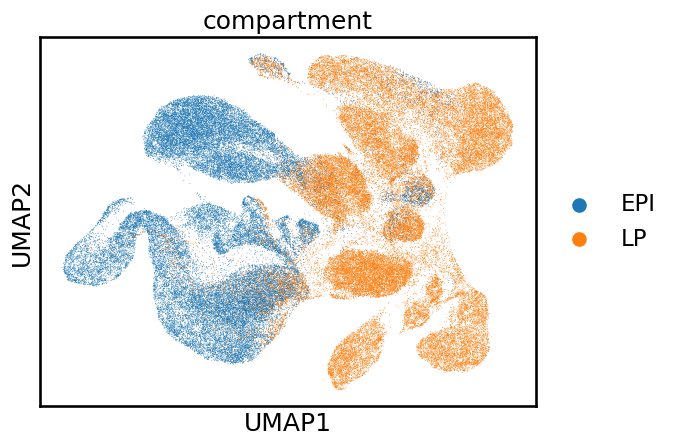

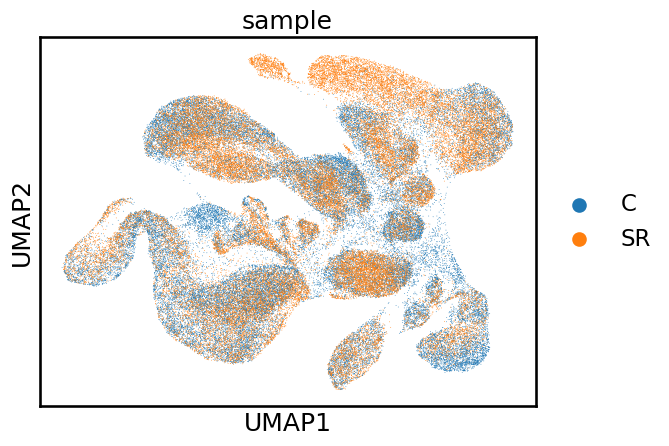

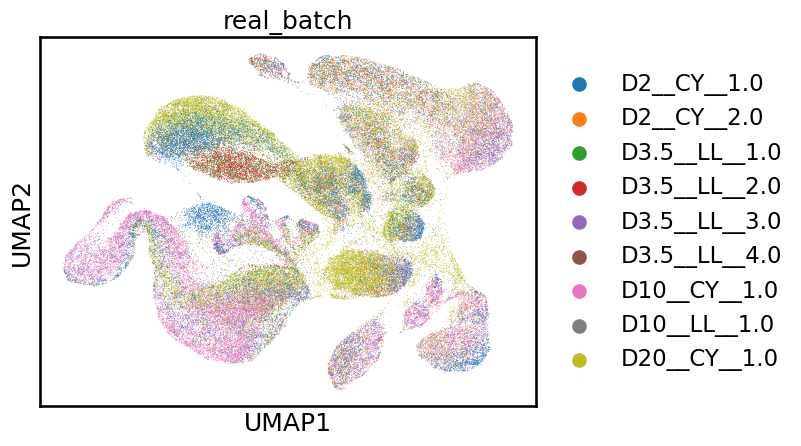

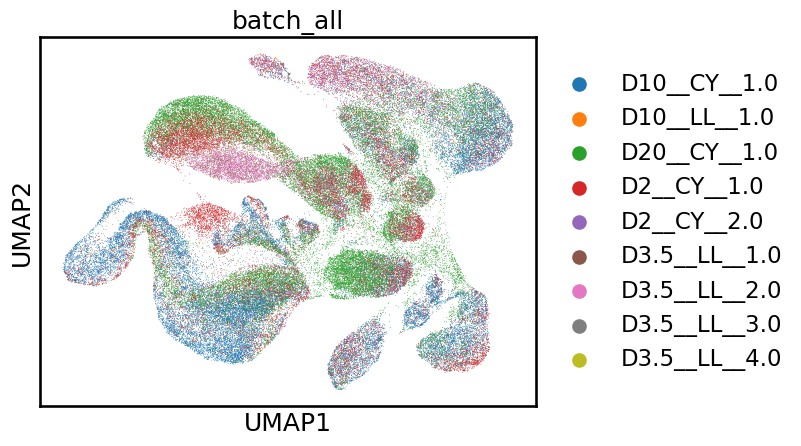

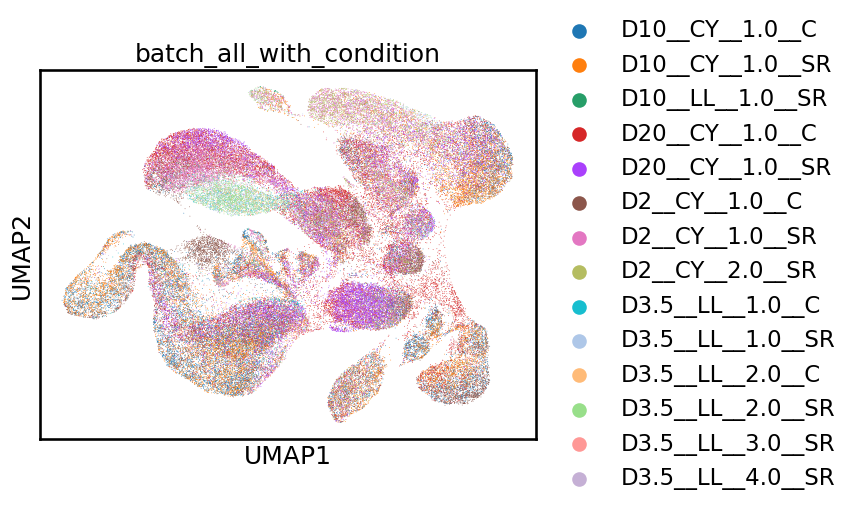

In [6]:
adata=sc.read_h5ad("../case_control/data/mouse.h5ad")
adata_latent=run_scdisinfact(adata=adata, batch_key='real_batch', condition_key="sample", cell_type_label='compartment', dataset_name="mouse")
evaluate_scd_comprehensive(adata=adata_latent, batch_key='real_batch', condition_key="sample", cell_type_label='compartment', dataset_name="mouse")

# SEA-AD dataset

https://cellxgene.cziscience.com/collections/1ca90a2d-2943-483d-b678-b809bf464c30

Sanity check...
Finished.
Create scDisInFact datasets...


Finished.


[[ 8.79673386e+00 -3.13089752e+00  2.58226871e+00 ...  9.67416316e-02
  -1.86013177e-01 -7.20714474e+00]
 [ 9.55627823e+00 -2.32690978e+00  2.71611047e+00 ...  6.81865573e-01
  -7.48835802e-02 -8.03187561e+00]
 [ 5.03685112e+01 -2.31897283e+00  2.01764259e+01 ... -1.87397537e+01
   1.67108703e+00 -2.74318466e+01]
 ...
 [ 6.74622574e+01  1.74721971e-01  2.57350502e+01 ... -3.68170700e+01
  -2.54930615e+00 -3.46461487e+01]
 [ 3.79490738e+01  1.21536124e+00  2.14292812e+01 ... -2.60646362e+01
  -8.28318000e-01 -2.27970200e+01]
 [ 1.57212105e+01  1.78597295e+00  1.62892866e+00 ... -5.68734503e+00
  -1.94237995e+00 -3.90233472e-02]]


AD adata preprocessing...
adata preprocessing...


batch_all ['H18.30.001' 'H18.30.002' 'H19.30.001' 'H19.30.002' 'H19.33.004'
 'H20.33.001' 'H20.33.002' 'H20.33.004' 'H20.33.005' 'H20.33.008'
 'H20.33.011' 'H20.33.012' 'H20.33.013' 'H20.33.014' 'H20.33.015'
 'H20.33.016' 'H20.33.017' 'H20.33.018' 'H20.33.019' 'H20.33.020'
 'H20.33.024' 'H20.33.025' 'H20.33.026' 'H20.33.027' 'H20.33.028'
 'H20.33.029' 'H20.33.030' 'H20.33.031' 'H20.33.032' 'H20.33.033'
 'H20.33.034' 'H20.33.035' 'H20.33.036' 'H20.33.037' 'H20.33.038'
 'H20.33.039' 'H20.33.040' 'H20.33.041' 'H20.33.043' 'H20.33.044'
 'H20.33.045' 'H20.33.046' 'H200.1023' 'H21.33.001' 'H21.33.002'
 'H21.33.003' 'H21.33.004' 'H21.33.005' 'H21.33.006' 'H21.33.007'
 'H21.33.008' 'H21.33.009' 'H21.33.010' 'H21.33.011' 'H21.33.012'
 'H21.33.013' 'H21.33.014' 'H21.33.015' 'H21.33.016' 'H21.33.017'
 'H21.33.018' 'H21.33.019' 'H21.33.020' 'H21.33.021' 'H21.33.022'
 'H21.33.023' 'H21.33.025' 'H21.33.026' 'H21.33.027' 'H21.33.028'
 'H21.33.029' 'H21.33.030' 'H21.33.031' 'H21.33.032' 'H21.33.033'
 

batch_all_with_condition ['H18.30.001__normal' 'H18.30.002__normal' 'H19.30.001__normal'
 'H19.30.002__normal' 'H19.33.004__normal' 'H20.33.001__normal'
 'H20.33.002__normal' 'H20.33.004__dementia' 'H20.33.005__normal'
 'H20.33.008__normal' 'H20.33.011__dementia' 'H20.33.012__normal'
 'H20.33.013__normal' 'H20.33.014__normal' 'H20.33.015__dementia'
 'H20.33.016__dementia' 'H20.33.017__dementia' 'H20.33.018__dementia'
 'H20.33.019__normal' 'H20.33.020__dementia' 'H20.33.024__normal'
 'H20.33.025__normal' 'H20.33.026__dementia' 'H20.33.027__normal'
 'H20.33.028__dementia' 'H20.33.029__dementia' 'H20.33.030__normal'
 'H20.33.031__dementia' 'H20.33.032__normal' 'H20.33.033__dementia'
 'H20.33.034__normal' 'H20.33.035__normal' 'H20.33.036__normal'
 'H20.33.037__dementia' 'H20.33.038__dementia' 'H20.33.039__normal'
 'H20.33.040__dementia' 'H20.33.041__dementia' 'H20.33.043__normal'
 'H20.33.044__normal' 'H20.33.045__dementia' 'H20.33.046__dementia'
 'H200.1023__normal' 'H21.33.001__dementia'

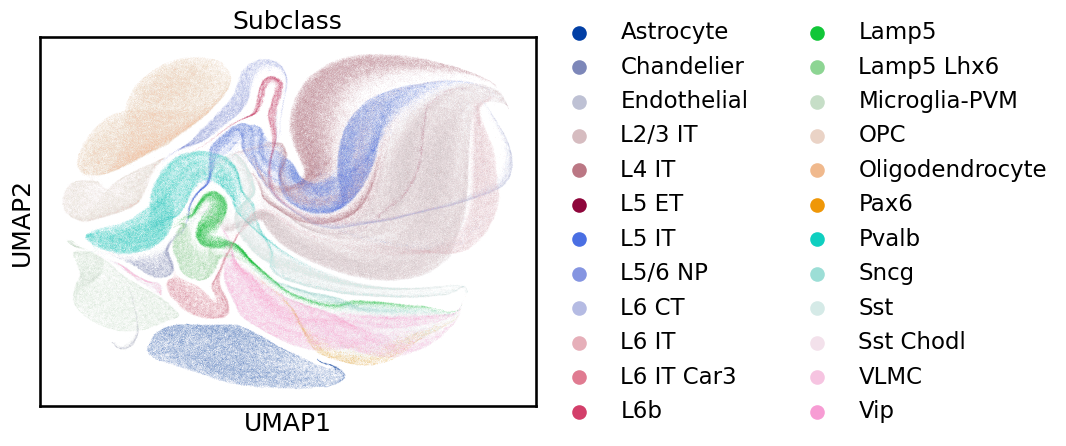

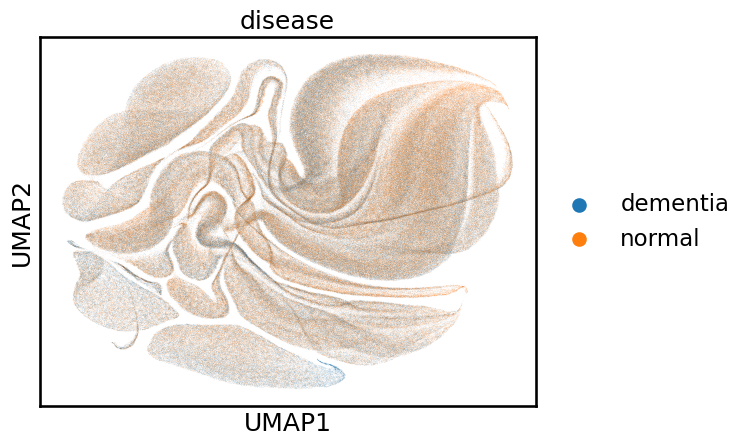

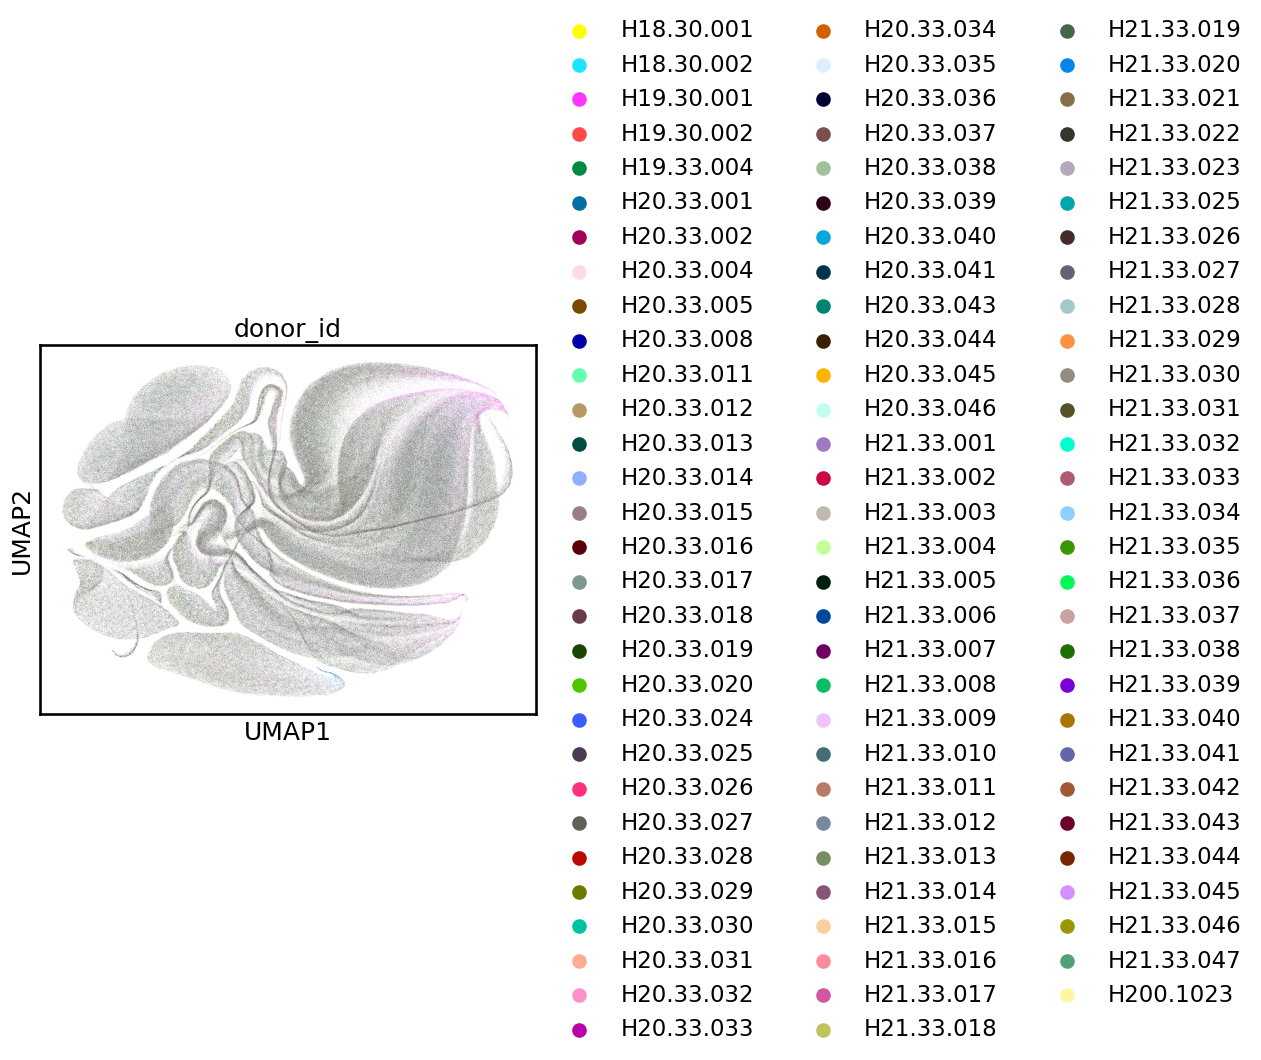

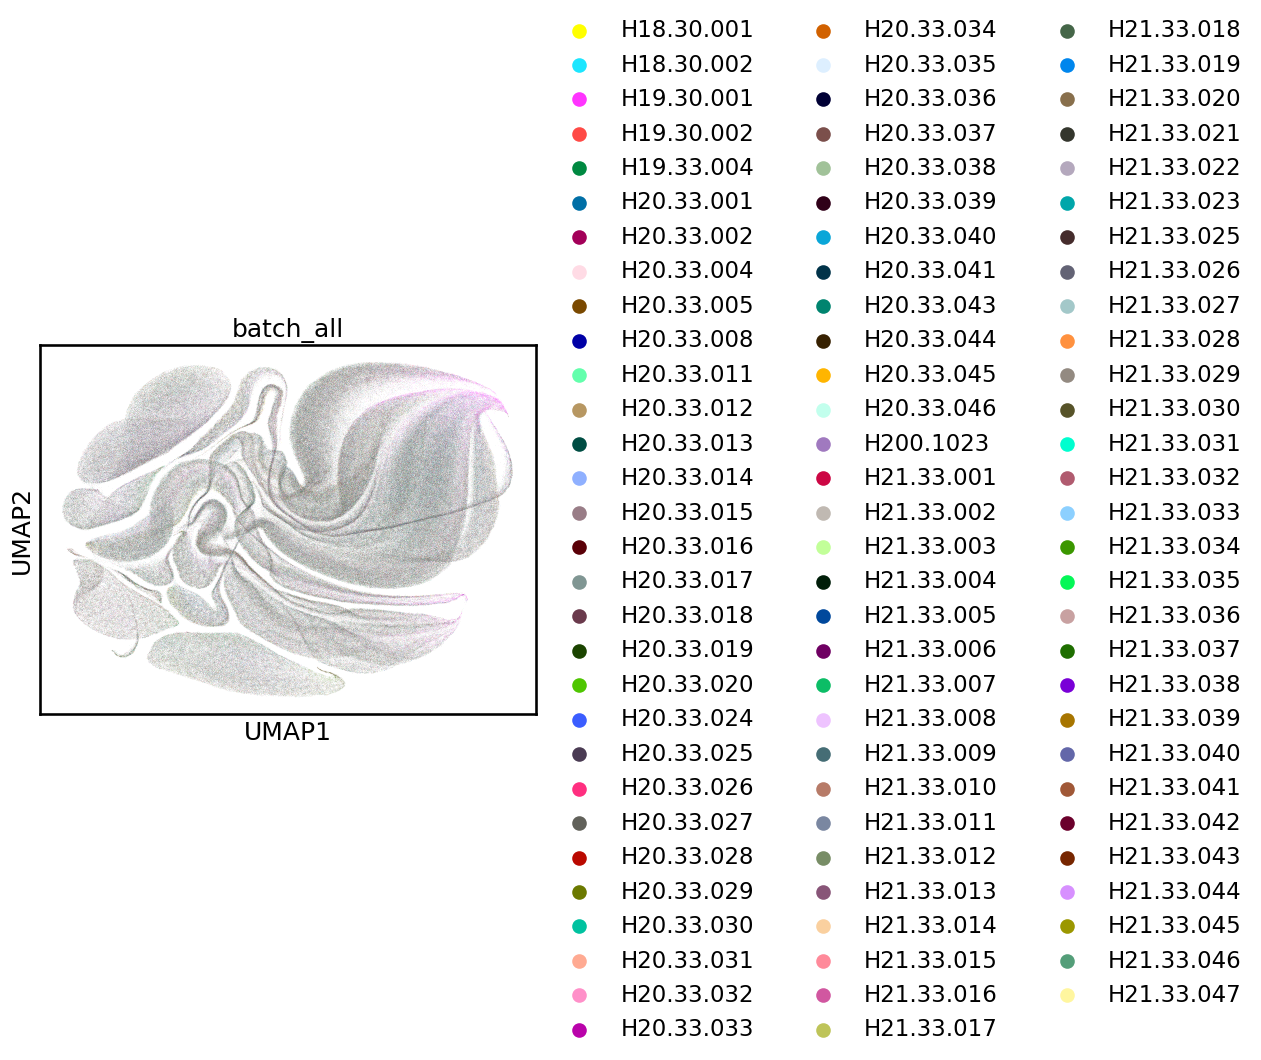

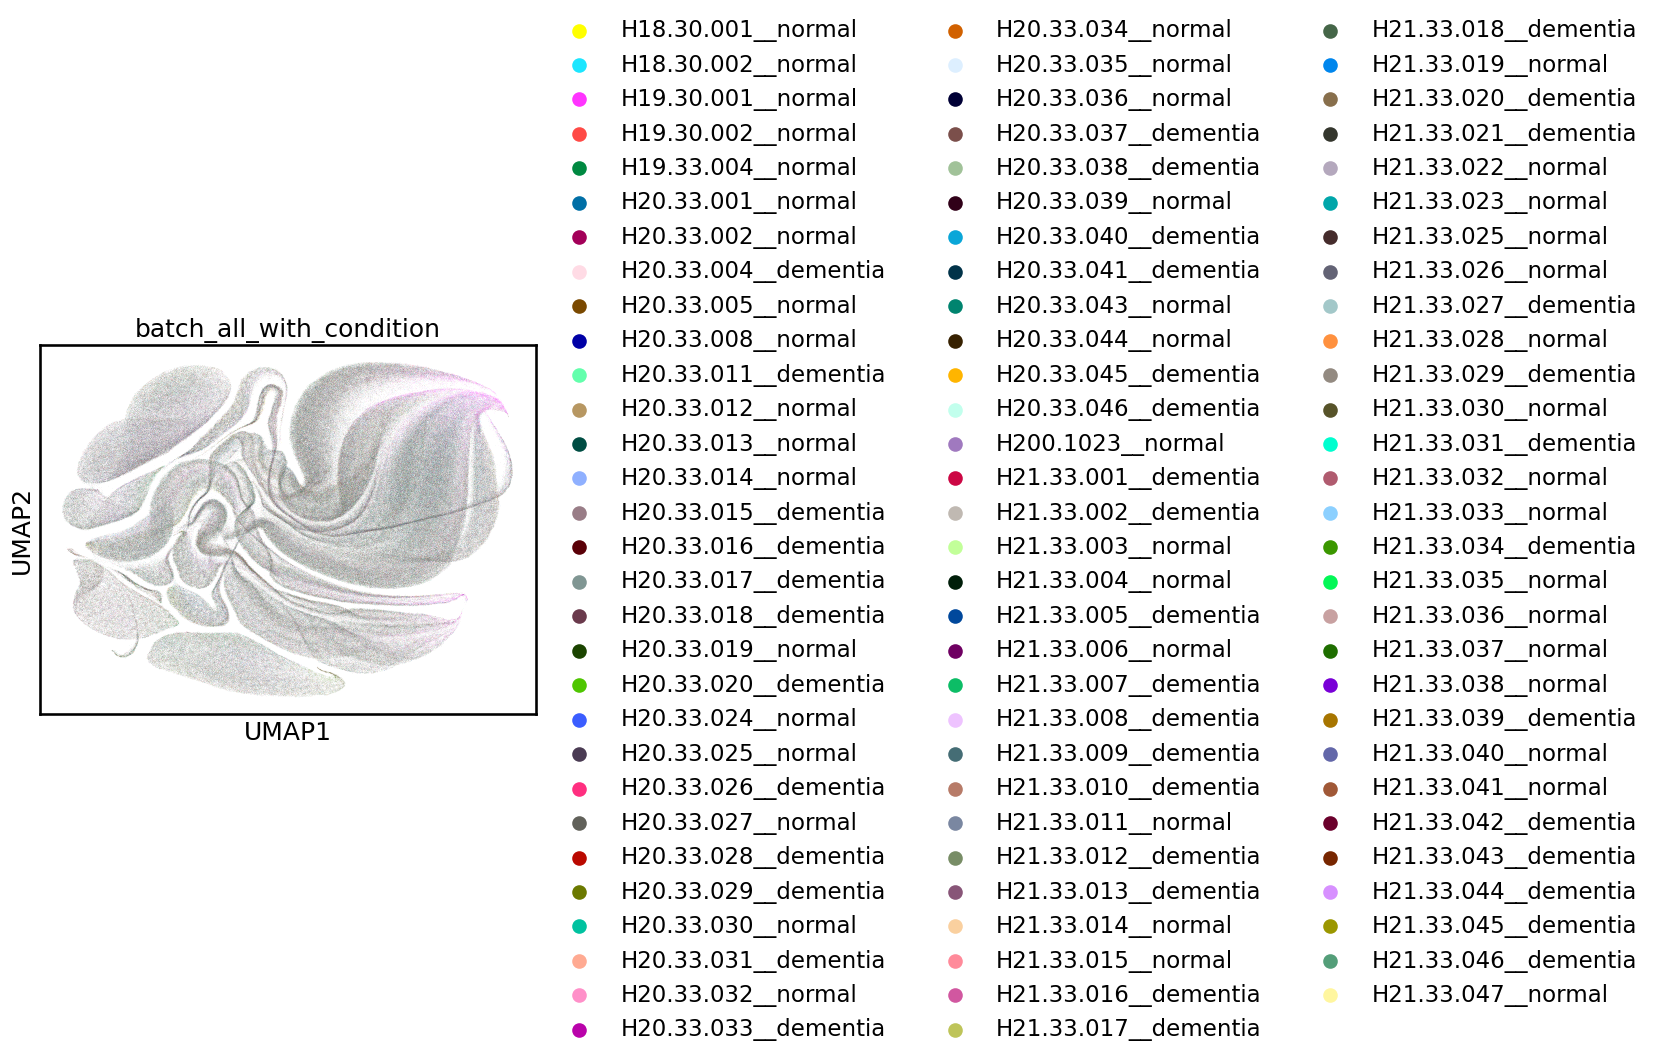

In [7]:
adata=sc.read_h5ad("../case_control/data/AD.h5ad")
adata.raw=None

adata_latent=run_scdisinfact(adata=adata, batch_key='donor_id', condition_key="disease", cell_type_label='Subclass', dataset_name="AD")
evaluate_scd_comprehensive(adata=adata_latent, batch_key='donor_id', condition_key="disease", cell_type_label='Subclass', dataset_name="AD")